In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# connect IMDB

con =sqlite3.connect('zippedData/im.db')

In [4]:
# IMDB select columns from movie_basics
# primary_name,original_title,genres,averagerating,numvotes
# order by primary_title

df_IMDB = pd.read_sql("""
SELECT b.primary_title,b.original_title,b.genres AS IMDB_genres,r.averagerating AS IMDB_ratings,r.numvotes AS IMDB_nvotes
FROM movie_ratings AS r
LEFT JOIN movie_basics AS b
ON r.movie_id = b.movie_id
ORDER BY b.primary_title
""",con)
df_IMDB.head()

,primary_title,original_title,IMDB_genres,IMDB_ratings,IMDB_nvotes
0,!Women Art Revolution,Women Art Revolution,Documentary,6.9,196
1,#1 Serial Killer,#1 Serial Killer,Horror,5.6,40
2,#5,#5,"Biography,Comedy,Fantasy",6.8,6
3,#66,#66,Action,5.3,18
4,#ALLMYMOVIES,#ALLMYMOVIES,Documentary,8.3,21


In [5]:
df_IMDB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   primary_title   73856 non-null  object 
 1   original_title  73856 non-null  object 
 2   IMDB_genres     73052 non-null  object 
 3   IMDB_ratings    73856 non-null  float64
 4   IMDB_nvotes     73856 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 2.8+ MB


In [6]:
# get TM movies CSV
# start to clean it
# use it to filter IMDB

df_tm_movies = pd.read_csv('zippedData/tmdb.movies.csv')
df_tm_movies

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...,...
26512,26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1
26513,26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1
26515,26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1


In [12]:
df_tm_movies_clean = df_tm_movies[['title','original_title','release_date','vote_average','vote_count']]
df_tm_movies_clean

,title,original_title,release_date,vote_average,vote_count
0,Harry Potter and the Deathly Hallows: Part 1,Harry Potter and the Deathly Hallows: Part 1,2010-11-19,7.7,10788
1,How to Train Your Dragon,How to Train Your Dragon,2010-03-26,7.7,7610
2,Iron Man 2,Iron Man 2,2010-05-07,6.8,12368
3,Toy Story,Toy Story,1995-11-22,7.9,10174
4,Inception,Inception,2010-07-16,8.3,22186
...,...,...,...,...,...
26512,Laboratory Conditions,Laboratory Conditions,2018-10-13,0.0,1
26513,_EXHIBIT_84xxx_,_EXHIBIT_84xxx_,2018-05-01,0.0,1
26514,The Last One,The Last One,2018-10-01,0.0,1
26515,Trailer Made,Trailer Made,2018-06-22,0.0,1


In [25]:
# join IMDB with TM

df_join = pd.merge(df_IMDB,df_tm_movies_clean,how='inner',left_on='primary_title',right_on='title')

In [26]:
df_join

,primary_title,original_title_x,IMDB_genres,IMDB_ratings,IMDB_nvotes,title,original_title_y,release_date,vote_average,vote_count
0,#ALLMYMOVIES,#ALLMYMOVIES,Documentary,8.3,21,#ALLMYMOVIES,#ALLMYMOVIES,2015-11-12,9.0,4
1,#Captured,#Captured,Thriller,2.8,212,#Captured,#Captured,2017-10-11,3.2,6
2,#FollowFriday,#FollowFriday,Thriller,2.8,186,#FollowFriday,#FollowFriday,2016-07-01,3.2,7
3,#Horror,#Horror,"Crime,Drama,Horror",3.0,3092,#Horror,#Horror,2015-11-20,3.3,102
4,#Lucky Number,#Lucky Number,Comedy,5.1,425,#Lucky Number,#Lucky Number,2015-09-01,6.0,2
...,...,...,...,...,...,...,...,...,...,...
19944,i hate myself :),i hate myself :),"Comedy,Documentary,Drama",7.7,46,i hate myself :),i hate myself :),2013-07-19,8.0,1
19945,iGirlfriend,iGirlfriend,Comedy,2.7,200,iGirlfriend,iGirlfriend,2017-01-15,4.0,4
19946,iSteve,iSteve,"Biography,Comedy",5.3,1098,iSteve,iSteve,2013-04-14,4.8,22
19947,xXx: Return of Xander Cage,xXx: Return of Xander Cage,"Action,Adventure,Thriller",5.2,77976,xXx: Return of Xander Cage,xXx: Return of Xander Cage,2017-01-20,5.6,2452


In [65]:
df_join_clean

,primary_title,original_title_x,IMDB_genres,IMDB_ratings,IMDB_nvotes,release_date,vote_average,vote_count
0,#ALLMYMOVIES,#ALLMYMOVIES,Documentary,8.3,21,2015-11-12,9.0,4
1,#Captured,#Captured,Thriller,2.8,212,2017-10-11,3.2,6
2,#FollowFriday,#FollowFriday,Thriller,2.8,186,2016-07-01,3.2,7
3,#Horror,#Horror,"Crime,Drama,Horror",3.0,3092,2015-11-20,3.3,102
4,#Lucky Number,#Lucky Number,Comedy,5.1,425,2015-09-01,6.0,2
...,...,...,...,...,...,...,...,...
19944,i hate myself :),i hate myself :),"Comedy,Documentary,Drama",7.7,46,2013-07-19,8.0,1
19945,iGirlfriend,iGirlfriend,Comedy,2.7,200,2017-01-15,4.0,4
19946,iSteve,iSteve,"Biography,Comedy",5.3,1098,2013-04-14,4.8,22
19947,xXx: Return of Xander Cage,xXx: Return of Xander Cage,"Action,Adventure,Thriller",5.2,77976,2017-01-20,5.6,2452


In [66]:
df_join_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19949 entries, 0 to 19948
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_title     19949 non-null  object 
 1   original_title_x  19949 non-null  object 
 2   IMDB_genres       19879 non-null  object 
 3   IMDB_ratings      19949 non-null  float64
 4   IMDB_nvotes       19949 non-null  int64  
 5   release_date      19949 non-null  object 
 6   vote_average      19949 non-null  float64
 7   vote_count        19949 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 2.0+ MB


In [69]:
df_join_clean['release_date'] = pd.to_datetime(df_join_clean['release_date'])

In [108]:
df_join_clean = df_join_clean.drop_duplicates()

In [109]:
df_join_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18830 entries, 0 to 19948
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   primary_title     18830 non-null  object        
 1   original_title_x  18830 non-null  object        
 2   IMDB_genres       18830 non-null  object        
 3   IMDB_ratings      18830 non-null  float64       
 4   IMDB_nvotes       18830 non-null  int64         
 5   release_date      18830 non-null  datetime64[ns]
 6   vote_average      18830 non-null  float64       
 7   vote_count        18830 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 1.3+ MB


In [ ]:
# find the most popular genre and genre combos

In [110]:
# unique genres and genre combos
# 617

len(df_join_clean['IMDB_genres'].unique())

617

In [122]:
first_100_genres = df_join_clean['IMDB_genres'].value_counts().head(100)

<AxesSubplot:>

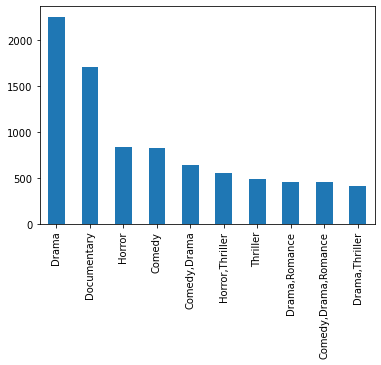

In [147]:
first_100_genres[:10].plot(kind='bar')

<AxesSubplot:>

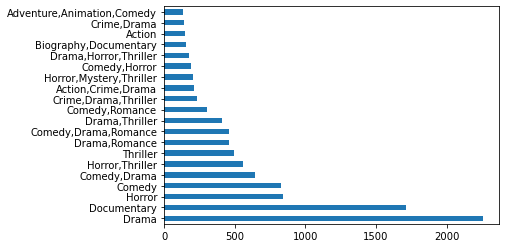

In [188]:
df_join_clean['IMDB_genres'].value_counts()[:20].plot(kind='barh')

In [140]:
# find unique genres
# try find the ones without comma
# 21

individual_genre = df_join_clean[df_join_clean['IMDB_genres'].str.contains(',')==False]['IMDB_genres'].unique()

In [157]:
df_game_movie = pd.read_csv('zippedData/List_of_highest-grossing_films_based_on_video_games_wikipedia.csv')

In [158]:
df_game_movie_clean = df_game_movie[['Title','Based on video game(s)','Original game publisher(s)','Distributor','Format']]

In [167]:
df_game_movie_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Title                       50 non-null     object
 1   Based on video game(s)      50 non-null     object
 2   Original game publisher(s)  50 non-null     object
 3   Distributor                 50 non-null     object
 4   Format                      50 non-null     object
dtypes: object(5)
memory usage: 2.1+ KB


<AxesSubplot:>

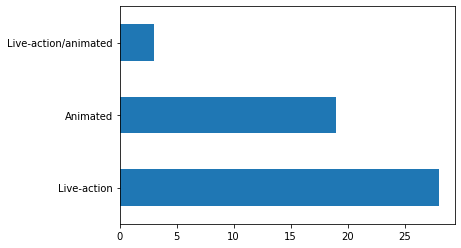

In [187]:
df_game_movie_clean['Format'].value_counts().plot(kind='barh')

In [177]:
df_game_movie_clean.head(10)

,Title,Based on video game(s),Original game publisher(s),Distributor,Format
0,Warcraft,Warcraft,Blizzard Entertainment,Universal Pictures,Live-action
1,Detective Pikachu,Detective Pikachu and Pokémon,"Nintendo, The Pokémon Company",Warner Bros. Pictures,Live-action/animated
2,Rampage,Rampage,Midway Games,Warner Bros. Pictures,Live-action
3,Sonic the Hedgehog 2,Sonic the Hedgehog,Sega,Paramount Pictures,Live-action/animated
4,Uncharted,Uncharted,Sony Interactive Entertainment,Sony Pictures Releasing,Live-action
5,The Angry Birds Movie,Angry Birds,Rovio Entertainment,Sony Pictures Releasing,Animated
6,Prince of Persia: The Sands of Time,Prince of Persia: The Sands of Time,Ubisoft,Walt Disney Studios Motion Pictures,Live-action
7,Sonic the Hedgehog,Sonic the Hedgehog,Sega,Paramount Pictures,Live-action/animated
8,Resident Evil: The Final Chapter,Resident Evil,Capcom,Sony Pictures Releasing,Live-action
9,Resident Evil: Afterlife,Resident Evil,Capcom,Sony Pictures Releasing,Live-action


In [ ]:
# combine BOM/TN with LIST of wikipedia game movie list

In [170]:
df_tn = pd.read_csv('zippedData/tn.movie_budgets.csv')

In [171]:
df_tn

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [174]:
df_join_wiki_tn = pd.merge(df_game_movie_clean,df_tn,how='left',right_on='movie',left_on='Title')

In [185]:
df_join_wiki_tn

,Title,Based on video game(s),Original game publisher(s),Distributor,Format,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,Warcraft,Warcraft,Blizzard Entertainment,Universal Pictures,Live-action,46.0,"Jun 10, 2016",Warcraft,"$160,000,000","$47,225,655","$425,522,281"
1,Detective Pikachu,Detective Pikachu and Pokémon,"Nintendo, The Pokémon Company",Warner Bros. Pictures,Live-action/animated,NaN,NaN,NaN,NaN,NaN,NaN
2,Rampage,Rampage,Midway Games,Warner Bros. Pictures,Live-action,90.0,"Apr 13, 2018",Rampage,"$120,000,000","$101,028,233","$428,056,280"
3,Sonic the Hedgehog 2,Sonic the Hedgehog,Sega,Paramount Pictures,Live-action/animated,NaN,NaN,NaN,NaN,NaN,NaN
4,Uncharted,Uncharted,Sony Interactive Entertainment,Sony Pictures Releasing,Live-action,NaN,NaN,NaN,NaN,NaN,NaN
5,The Angry Birds Movie,Angry Birds,Rovio Entertainment,Sony Pictures Releasing,Animated,77.0,"May 20, 2016",The Angry Birds Movie,"$73,000,000","$107,509,366","$352,327,887"
6,Prince of Persia: The Sands of Time,Prince of Persia: The Sands of Time,Ubisoft,Walt Disney Studios Motion Pictures,Live-action,NaN,NaN,NaN,NaN,NaN,NaN
7,Sonic the Hedgehog,Sonic the Hedgehog,Sega,Paramount Pictures,Live-action/animated,NaN,NaN,NaN,NaN,NaN,NaN
8,Resident Evil: The Final Chapter,Resident Evil,Capcom,Sony Pictures Releasing,Live-action,84.0,"Jan 27, 2017",Resident Evil: The Final Chapter,"$40,000,000","$26,844,692","$314,101,190"
9,Resident Evil: Afterlife,Resident Evil,Capcom,Sony Pictures Releasing,Live-action,70.0,"Sep 10, 2010",Resident Evil: Afterlife,"$57,500,000","$60,128,566","$295,874,190"


In [194]:
df_tn[df_tn['movie'].str.contains('Pikachu')]['movie']='Detective Pikachu'

175    PokÃ©mon: Detective Pikachu
Name: movie, dtype: object

In [ ]:
# find dataset on Kaggle
# https://www.kaggle.com/datasets/bcruise/film-adaptations-of-video-games

In [195]:
df_kaggle_game = pd.read_csv('zippedData/video_game_films.csv')

In [198]:
df_kaggle_game.head()

,Title,Release date,Worldwide box office,Rotten Tomatoes,Metacritic,Distributor,Original game publisher
0,Super Mario Bros.,1993-05-28,38912465.0,24.0,35.0,Buena Vista Pictures Distribution,Nintendo
1,Double Dragon,1994-11-04,4152699.0,13.0,NaN,Gramercy Pictures,Technōs Japan
2,Street Fighter,1994-12-23,99423521.0,13.0,34.0,Universal Pictures,Capcom
3,Mortal Kombat,1995-08-18,124741822.0,44.0,60.0,New Line Cinema,Midway
4,Mortal Kombat: Annihilation,1997-11-21,51376861.0,2.0,11.0,New Line Cinema,Midway


In [204]:
df_kaggle_game['Release date'] = pd.to_datetime(df_kaggle_game['Release date'])

In [212]:
df_kaggle_game['Release date'].value_counts()

2010-09-10    1
2015-08-21    1
2006-04-21    1
2019-05-10    1
2017-01-27    1
2018-03-16    1
2019-05-03    1
2016-06-10    1
2020-12-18    1
2008-10-02    1
2005-10-21    1
2018-04-13    1
2021-06-25    1
2010-05-28    1
1999-03-12    1
2008-01-11    1
2010-03-20    1
2009-02-27    1
2007-10-18    1
2003-10-10    1
1993-05-28    1
2020-02-14    1
2007-11-21    1
2008-10-17    1
2001-06-15    1
2012-10-26    1
2014-03-14    1
1994-11-04    1
2012-09-14    1
2006-09-07    1
2002-03-15    1
2021-04-23    1
2021-11-24    1
1994-12-23    1
2007-09-21    1
1997-11-21    1
2016-12-21    1
2004-09-10    1
2003-07-25    1
2006-01-06    1
2005-01-28    1
1995-08-18    1
Name: Release date, dtype: int64